# Clarification about Project Part 1

Simple (no compartments) SIR model:

$$
\frac{dS(t)}{dt}=-\frac{\beta S(t) I(t)}{N}\\
\frac{dI(t)}{dt}=\frac{\beta S(t) I(t)}{N}-\gamma I(t)=-\frac{dS(t)}{dt}-\gamma I(t)\\
\frac{dR(t)}{dt}=\gamma I(t)
$$

Some points to clarify:

- We don't need to solve the differential equation ourselves. We simply need to write the function that describes the behavior i.e. right hand side and pass it to `scipy.integrate.solve_ivp`. It solves the system of equations over time for us.
- Your function that defines the RHS of the equations needs to follow a strict function signature (input output types, sizes and order). 
- Calculation of $L(t)$ (viral load) is not part of the system of equations. We can calculate it only after w solve the system of ODEs and know the value of $I(t)$. $L(t)=\sum_c L_c I_c(t)$

Additional remark:
- Please get used to working with numpy arrays it makes life easier and programs much faster.

```
some_list=[1,2,3,4,5,6,7,8,9,10]
other_list=[1,2,3,4,5,6,7,8,9,10]
for i in range(10):
    some_list[i]=some_list[i]+other_list[i]
```

is equivalent to 


```
some_array=np.array([1,2,3,4,5,6,7,8,9,10])
other_array=np.array([1,2,3,4,5,6,7,8,9,10])

some_array=some_array+other_array
```

and is much easier to read and faster to run.


## Example using the simple SIR model and what the curves should look like

In [1]:
import numpy as np

# Notice the function signature
def SIR_model(t, Y_vector, beta, gamma):
    # now we define what the right hand side does.
    S=Y_vector[0]
    I=Y_vector[1]
    R=Y_vector[2]
    
    dS_dt = -S*I*beta/N
    dI_dt = -dS_dt-gamma*I
    dR_dt = gamma*I
    
    # if one of dS_dt,dI_dt,dR_dt was an array we would use np.concatenate
    return np.array([dS_dt,dI_dt,dR_dt]) 

In [2]:
from scipy.integrate import solve_ivp

beta_true=0.3
gamma_true=1/10
N=10000
Lc=1.5

t=np.linspace(0,119,120)

initial_I=13
initial_R=0
# make sure you compute initial_S it this way
initial_S=N-initial_I-initial_R

# notice that each initial condition is 
# for the corresponding equation at the same index
initial_conditions=np.array([initial_S, initial_I, initial_R])

soln_obj = solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
                             t_eval=t, args=(beta_true, gamma_true))

# if you didn't specify t_eval you would need to call
# soln_obj = solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
#                             dense_output=True, args=(beta_true, gamma_true))
# soln_obj.sol(t)

In [3]:
print(soln_obj.t)
print(soln_obj.y.shape)
print(soln_obj.y)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]
(3, 120)
[[9.98700000e+03 9.98269015e+03 9.97743077e+03 9.97101624e+03
  9.96319435e+03 9.95365731e+03 9.94203657e+03 9.92789145e+03
  9.91068864e+03 9.88976795e+03 9.86434104e+03 9.83349141e+03
  9.79617701e+03 9.75111221e+03 9.69672549e+03 9.63123971e+03
  9.55267371e+03 9.45884233e+03 9.34735638e+03 9.21605459e+03
  9.06211319e+03 8.88201515e+03 8.67316069e+03 8.43388514e+03
  8.16345

Let's plot and see what $S(t)$, $I(t)$ and $R(t)$ look like over time.

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

# S_over_time, I_over_time, R_over_time = soln_obj.y

S_over_time=soln_obj.y[0]
I_over_time=soln_obj.y[1]
R_over_time=soln_obj.y[2]

# compute L(t) after solving ODEs
L_over_time=Lc*I_over_time

plt.figure()
plt.plot(t, S_over_time, label="S(t)")
plt.plot(t, I_over_time, label="I(t)")
plt.plot(t, R_over_time, label="R(t)")
plt.xlabel("t (days)")
plt.legend()

<IPython.core.display.Javascript object>

## Going from data to parameters

In [5]:
observed_data=L_over_time

In [6]:
from itertools import product
from sklearn.metrics import mean_squared_error

beta_grid=np.linspace(0.1,2.0,10)
gamma_grid=np.linspace(0.1,2.0,10)

mmse=np.inf
beta_mmse=gamma_mmse=np.nan

for (beta,gamma) in product(beta_grid, gamma_grid):
    
    soln_obj=solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
                                 t_eval=t, args=(beta, gamma))
    

    S_predicted=soln_obj.y[0]
    I_predicted=soln_obj.y[1]
    R_predicted=soln_obj.y[2]
    L_predicted=Lc*I_predicted

    mse = mean_squared_error(observed_data, L_predicted) 
    
    if mse<mmse:
        mmse = mse
        beta_mmse=beta
        gamma_mmse=gamma
        
print(f"True values are beta={beta_true:.2f}, gamma={gamma_true:.2f}")
print(f"Estimated values are beta={beta_mmse:.2f}, gamma={gamma_mmse:.2f}")


True values are beta=0.30, gamma=0.10
Estimated values are beta=0.31, gamma=0.10


<IPython.core.display.Javascript object>


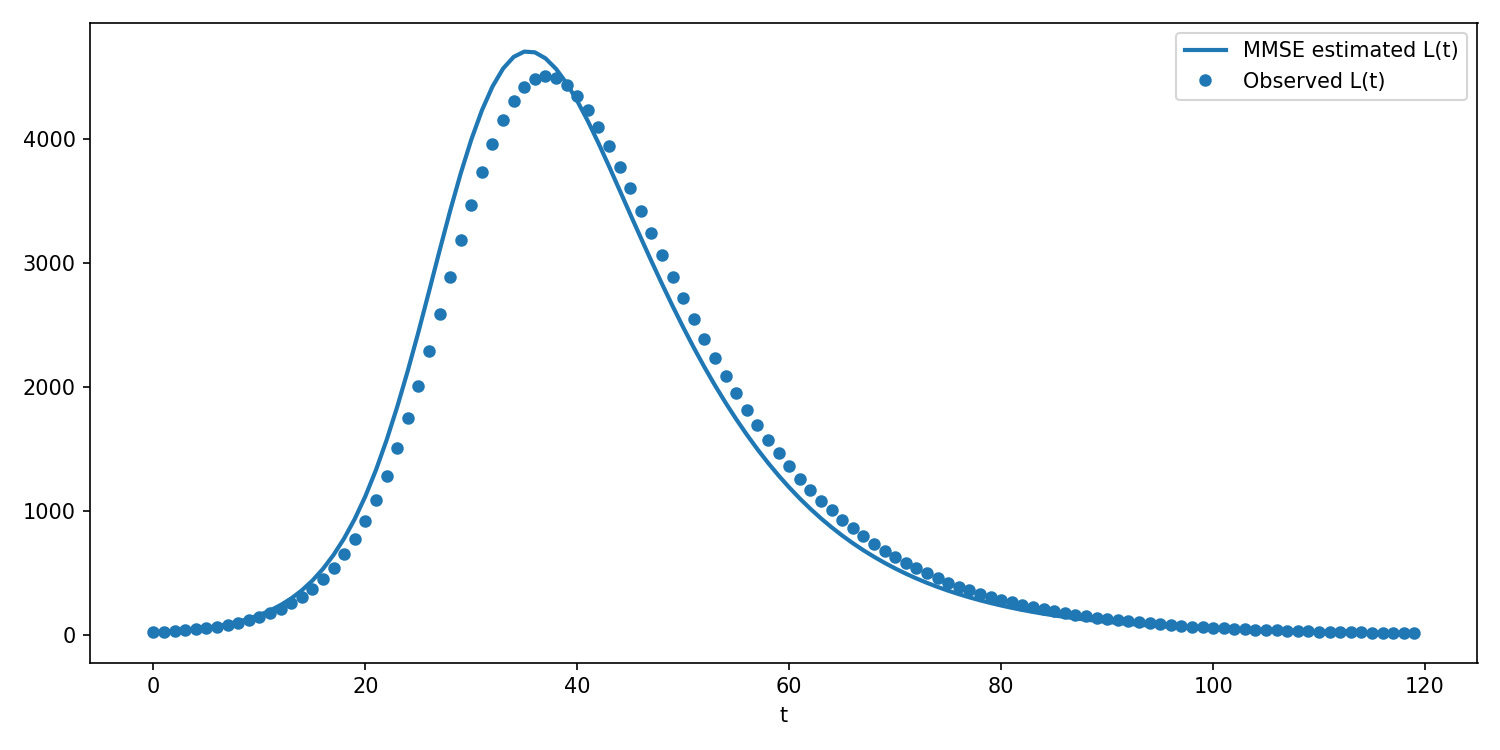

In [8]:
import matplotlib as mpl

soln_obj = solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
                                 t_eval=t, args=(beta_mmse, gamma_mmse))
    

mpl.style.use('default')
plt.figure(figsize=(10,5))
p0=plt.plot(t, Lc*soln_obj.y[1], linewidth=2, label="MMSE estimated L(t)")
plt.plot(t, observed_data, 'o', label="Observed L(t)", color=p0[0].get_color(), markersize=5)
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()

What if we have multiple nodes? (They share the $\beta$ and $\gamma$)

In [9]:
nb_nodes=3

beta_true=0.3
gamma_true=1/10
N=10000
Lc=1.5

t=np.linspace(0,119,120)

initial_I=np.array([13,20,5])
initial_R=np.zeros((nb_nodes))
initial_S=N-initial_I-initial_R

L_multiple_nodes=np.zeros((nb_nodes, len(t)))

for node_index in range(nb_nodes):
    initial_conditions=np.array([initial_S[node_index], initial_I[node_index], initial_R[node_index]])

    soln_obj=solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
                                 t_eval=t, args=(beta_true, gamma_true))

    S_over_time=soln_obj.y[0]
    I_over_time=soln_obj.y[1]
    R_over_time=soln_obj.y[2]

    
    L_multiple_nodes[node_index]=Lc*I_over_time



In [10]:
observed_data=L_multiple_nodes

beta_grid=np.linspace(0.1,2.0,20)
gamma_grid=np.linspace(0.1,2.0,20)

mmse=np.inf
beta_mmse=gamma_mmse=np.nan

for (beta,gamma) in product(beta_grid, gamma_grid):
    cumulative_mse = 0.
    
    for node_index in range(nb_nodes):
        initial_conditions=np.array([initial_S[node_index], initial_I[node_index], initial_R[node_index]])

        soln_obj=solve_ivp(SIR_model, (t[0], t[-1]), initial_conditions,\
                                     t_eval=t, args=(beta, gamma))


        S_predicted=soln_obj.y[0]
        I_predicted=soln_obj.y[1]
        R_predicted=soln_obj.y[2]
        L_predicted=Lc*I_predicted

        cumulative_mse += mean_squared_error(observed_data[node_index], L_predicted) 
    
    if cumulative_mse<mmse:
        mmse = mse
        beta_mmse=beta
        gamma_mmse=gamma
        
print(f"True values are beta={beta_true:.2f}, gamma={gamma_true:.2f}")
print(f"Estimated values are beta={beta_mmse:.2f}, gamma={gamma_mmse:.2f}")


True values are beta=0.30, gamma=0.10
Estimated values are beta=0.30, gamma=0.10


More remarks:

- Why did we divide $S$ into v and c compartments?  Because we wanted to make the model more granular
- In part (a) there is one node and there's population in each v and c bin. Therefore all 21 equations are used when solving the system of ODEs for that node
- In part (b), for a given SV compartment (let's say v=2) there are 5 nodes in that compartment. We are saying that for these 5 nodes, there is **no** population in bins where v=0, v=1 and v=3. Therefore we don't need to use 12 $dS/dt$ equations for these 5 nodes. This reduces the amount of equations to 9.
- Why did we do that? Because grid search is expensive. If you had to search over (grid granularity)$^{16}$ it would take an enormous amount of time. With the reduced number of equations you only need to search (grid granularity)$^{4}$ combinations. Also, solving 9 equations is slightly faster than solving 21 equations.

For example, the 21 equations:
$$\frac{dS_{0,0}}{dt}=...$$
$$\frac{dS_{0,1}}{dt}=...$$
$$\frac{dS_{0,2}}{dt}=...$$
$$\frac{dS_{0,3}}{dt}=...$$
$$\frac{dS_{1,0}}{dt}=...$$
$$\frac{dS_{1,1}}{dt}=...$$
$$\frac{dS_{1,2}}{dt}=...$$
$$\frac{dS_{1,3}}{dt}=...$$
$$\frac{dS_{2,0}}{dt}=...$$
$$\frac{dS_{2,1}}{dt}=...$$
$$\frac{dS_{2,2}}{dt}=...$$
$$\frac{dS_{2,3}}{dt}=...$$
$$\frac{dS_{3,0}}{dt}=...$$
$$\frac{dS_{3,1}}{dt}=...$$
$$\frac{dS_{3,2}}{dt}=...$$
$$\frac{dS_{3,3}}{dt}=...$$
$$\frac{dI_{0}}{dt}=...$$
$$\frac{dI_{1}}{dt}=...$$
$$\frac{dI_{2}}{dt}=...$$
$$\frac{dI_{3}}{dt}=...$$
$$\frac{dR}{dt}=...$$

become 

$$\frac{dS_{1,0}}{dt}=...$$
$$\frac{dS_{1,1}}{dt}=...$$
$$\frac{dS_{1,2}}{dt}=...$$
$$\frac{dS_{1,3}}{dt}=...$$
$$\frac{dI_{0}}{dt}=...$$
$$\frac{dI_{1}}{dt}=...$$
$$\frac{dI_{2}}{dt}=...$$
$$\frac{dI_{3}}{dt}=...$$
$$\frac{dR}{dt}=...$$

if we know that this node only has population in $S_{1,c}$ bins i.e. $v=1$.